In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import torch
import random
import numpy as np
import pandas as pd

In [3]:
os.chdir('/content/drive/MyDrive/twitter_graph')

In [4]:
tweet_dataset = pd.read_csv('tweets.csv', usecols=[0, 1, 5], header=None)
tweet_dataset = tweet_dataset.iloc[1:]
#remove URL
tweet_dataset[1] = tweet_dataset[1].replace(to_replace="(http|https):\/\/([\w\s\d\.]+)(\/?)(.*)", value='', regex=True)
#remove MENTIONS
tweet_dataset[1] = tweet_dataset[1].replace(to_replace="@", value='', regex=True)
tweet_dataset[1] = tweet_dataset[1].replace(to_replace="#", value='', regex=True)

In [5]:
tweet_dataset.head()

,0,1,5
1,katyperry,Is history repeating itself...?DONTNORMALIZEHATE,en
2,katyperry,barackobama Thank you for your incredible grac...,en
3,katyperry,Life goals.,en
4,katyperry,Me right now 🙏🏻,en
5,katyperry,SISTERS ARE DOIN' IT FOR THEMSELVES! 🙌🏻💪🏻❤️,en


In [6]:
tweet_dataset.to_csv('filtered_tweet.csv')

In [7]:
!pip install sentence-transformers

     |████████████████████████████████| 79 kB 3.2 MB/s 
     |████████████████████████████████| 4.2 MB 25.7 MB/s 
     |████████████████████████████████| 1.2 MB 21.3 MB/s 
     |████████████████████████████████| 84 kB 2.8 MB/s 
     |████████████████████████████████| 6.6 MB 37.9 MB/s 
     |████████████████████████████████| 596 kB 51.8 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.0-py3-none-any.whl size=120747 sha256=e028976ba5f9b651e3ecb670052f40dcde03fc33975c65c5127fc940c455475c
  Stored in directory: /root/.cache/pip/wheels/83/c0/df/b6873ab7aac3f2465aa9144b6b4c41c4391cfecc027c8b07e7
Successfully built sentence-transformers
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [8]:
from torch.utils.data import DataLoader
import csv
from sentence_transformers import SentenceTransformer, InputExample
from collections import OrderedDict

In [9]:
with open('filtered_tweet.csv', 'r', newline='') as fr:
  csv_reader = csv.reader(fr)
  next(csv_reader)
  author_list = OrderedDict()
  for _, author, tweet, language in csv_reader:
    if language != 'en' or len(tweet) < 15:
      continue
    author_list[tweet] = author

embedding_list = list(author_list.keys())

In [10]:
model = SentenceTransformer('distilbert-base-nli-mean-tokens')
embeddings = model.encode(embedding_list, show_progress_bar=True)

Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.99k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/550 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/265M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/450 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Batches:   0%|          | 0/1408 [00:00<?, ?it/s]

In [11]:
embedding_pairs = list(zip(embedding_list, embeddings))
author_tweet_embedding_dict = OrderedDict()
for x,y in embedding_pairs:
  author_tweet_embedding_dict[author_list[x]] = (x, y)

In [12]:
import pickle
with open('author_tweet_embedding_dict.pickle', 'wb') as handle:
    pickle.dump(author_tweet_embedding_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [13]:
!pip install umap-learn

     |████████████████████████████████| 88 kB 3.1 MB/s 
     |████████████████████████████████| 1.1 MB 12.6 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82829 sha256=83e9ab22928374f23710890f79f7f3e37757e411b2f45b97326bd9365d22621f
  Stored in directory: /root/.cache/pip/wheels/b3/52/a5/1fd9e3e76a7ab34f134c07469cd6f16e27ef3a37aeff1fe821
  Created wheel for pynndescent: filename=pynndescent-0.5.6-py3-none-any.whl size=53943 sha256=8ada5716c29bd9eca3f9b0449ac49420bfe86d3a467405b4cec84f9f2db0a9e8
  Stored in directory: /root/.cache/pip/wheels/03/f1/56/f80d72741e400345b5a5b50ec3d929aca581bf45e0225d5c50
Successfully built umap-learn pynndescent


In [14]:
len(embedding_pairs)

45029

In [15]:
import umap
umap_embeddings = umap.UMAP(n_neighbors=15, 
                            n_components=5, 
                            metric='cosine').fit_transform(embeddings)

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


In [16]:
len(umap_embeddings)

45029

In [17]:
embedding_umap_pairs = list(zip(embeddings, umap_embeddings))
with open('embedding_umap_pairs.pickle', 'wb') as handle:
    pickle.dump(embedding_umap_pairs, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [18]:
!pip install hdbscan

     |████████████████████████████████| 5.2 MB 3.9 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for hdbscan: filename=hdbscan-0.8.28-cp37-cp37m-linux_x86_64.whl size=2330811 sha256=6e49fdd52010e774ef8b1911a5c0ad22d7d0a924c723ceb3d76eea87103beed9
  Stored in directory: /root/.cache/pip/wheels/6e/7a/5e/259ccc841c085fc41b99ef4a71e896b62f5161f2bc8a14c97a
Successfully built hdbscan


In [19]:
import hdbscan
cluster = hdbscan.HDBSCAN(min_cluster_size=15,
                          metric='euclidean',                      
                          cluster_selection_method='eom').fit(umap_embeddings)

In [20]:
with open('cluster.pickle', 'wb') as handle:
    pickle.dump(cluster, handle, protocol=pickle.HIGHEST_PROTOCOL)

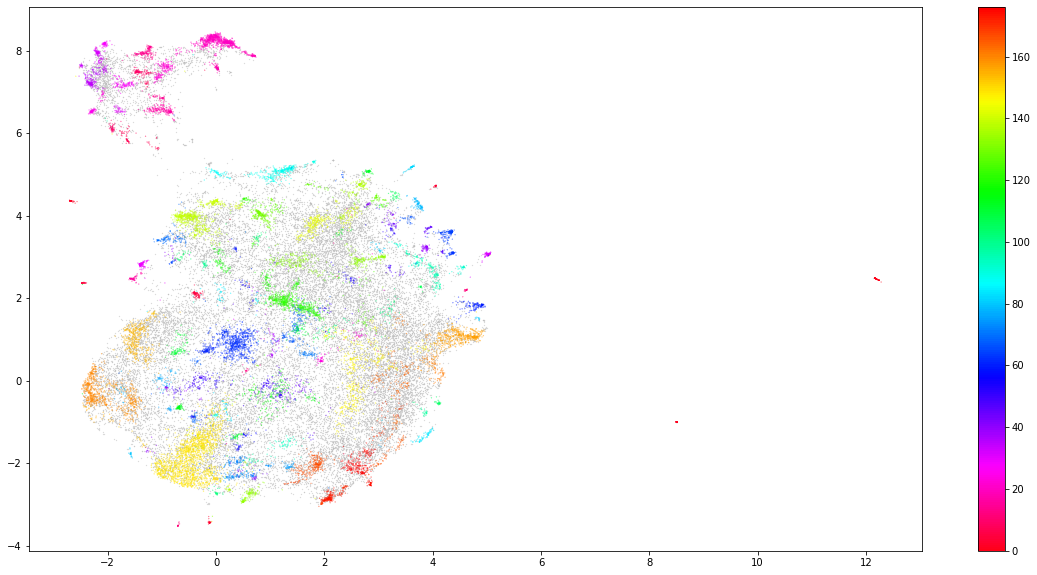

In [21]:
import matplotlib.pyplot as plt

# Prepare data
umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap='hsv_r')
plt.colorbar()

In [22]:
tweets_df = pd.DataFrame(list(author_list.keys()), columns=["Tweet"])
tweets_df['Topic'] = cluster.labels_
tweets_df['Tweet_ID'] = range(len(tweets_df))

In [23]:
tweets_per_topic = tweets_df.groupby(['Topic'], as_index = False).agg({'Tweet': ' '.join})

In [24]:
from sklearn.feature_extraction.text import CountVectorizer

def c_tf_idf(tweets, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(tweets)
    t = count.transform(tweets).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count
  
tf_idf, count = c_tf_idf(tweets_per_topic.Tweet.values, m=len(list(author_list.keys())))

In [25]:
def extract_top_n_words_per_topic(tf_idf, count, tweets_per_topic, n=20):
    words = count.get_feature_names()
    labels = list(tweets_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .Tweet
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "Tweet": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

top_n_words = extract_top_n_words_per_topic(tf_idf, count, tweets_per_topic, n=20)
topic_sizes = extract_topic_sizes(tweets_df); topic_sizes.head(10)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,Topic,Size
0,-1,28790
150,149,1780
21,20,816
63,62,677
122,121,555
161,160,512
158,157,510
140,139,510
155,154,402
148,147,356


In [26]:
top_n_words[18][:5]

[('died', 0.3436459468072625),
 ('says', 0.16898996649314854),
 ('dies', 0.12157400067368566),
 ('age', 0.11789948111611635),
 ('actor', 0.05673329183909133)]

In [27]:
with open('top_n_words.pickle', 'wb') as handle:
    pickle.dump(top_n_words, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [28]:
with open('tweets_per_topic.pickle', 'wb') as handle:
    pickle.dump(tweets_per_topic, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [29]:
with open('tweets_df.pickle', 'wb') as handle:
    pickle.dump(tweets_df, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [30]:
tweet_topic_dict = dict(zip(tweets_df['Tweet'], tweets_df['Topic']))

In [55]:
from collections import defaultdict
final_big_dict = dict()
# for x in tweet_topic_dict:
#   words = {t[0] for t in top_n_words[tweet_topic_dict[x]][:5]}
#   words = words - {'amp'}
#   final_big_dict[author_list[x]].append((x, tweet_topic_dict[x], list(words)))
for x in tweet_topic_dict:
  words = {t[0] for t in top_n_words[tweet_topic_dict[x]][:10]} - {'amp'}
  for word in words:
    if author_list[x] not in final_big_dict:
      final_big_dict[author_list[x]] = defaultdict(int)
    final_big_dict[author_list[x]][word] += 1
  

In [58]:
authors = list(final_big_dict.keys())
author_word_dict = defaultdict(list)
for author in authors:
  author_word_dict[author] = sorted(final_big_dict[author], key=final_big_dict[author].get, reverse=True)[:10]
print(author_word_dict)

defaultdict(<class 'list'>, {'katyperry': ['like', 'time', 'love', 'just', 'day', 'new', 'thank', 'tonight', 'today', 'know'], 'ddlovato': ['like', 'love', 'time', 'thank', 'day', 'just', 'new', 'tonight', 'today', 'know'], 'justinbieber': ['like', 'time', 'love', 'tonight', 'new', 'thank', 'day', 'just', 'today', 'ready'], 'taylorswift13': ['like', 'love', 'time', 'thank', 'tonight', 'new', 'just', 'day', 'today', 'yes'], 'BarackObama': ['like', 'time', 'love', 'day', 'thank', 'today', 'just', 'new', 'tonight', 'obama'], 'rihanna': ['like', 'time', 'love', 'day', 'new', 'thank', 'tonight', 'just', 'today', 'know'], 'ArianaGrande': ['love', 'like', 'time', 'thank', 'day', 'just', 'tonight', 'today', 'new', 'know'], 'YouTube': ['like', 'time', 'love', 'just', 'new', 'thank', 'day', 'tonight', 'today', 'know'], 'ladygaga': ['like', 'love', 'thank', 'time', 'new', 'day', 'tonight', 'just', 'today', 'know'], 'Twitter': ['new', 'like', 'thank', 'time', 'just', 'love', 'day', 'today', 'tonig

In [33]:
# with open('final_big_dict.pickle', 'wb') as handle:
#     pickle.dump(final_big_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [34]:
# # Generate tweet_author & topics csv
# def generate_author_topic_csv():
#     write_header = True
#     header = ['author', 'topics']
#     csv_file = "author_topic_dataset.csv"
#     with open(csv_file, 'w', newline='') as csv_file_descriptor:
#         csv_writer = csv.writer(csv_file_descriptor)
#         csv_writer.writerow(header)
#         for k in final_big_dict:
#             for tups in final_big_dict[k]:
#                 csv_writer.writerow([k, tups[2]])

# generate_author_topic_csv()

In [35]:
# def generate_author_topic_csv():
#     write_header = True
#     header = ['author', 'topic1', 'topic2', 'topic3']
#     csv_file = "author_topic_dataset.csv"
#     with open(csv_file, 'w', newline='') as csv_file_descriptor:
#         csv_writer = csv.writer(csv_file_descriptor)
#         csv_writer.writerow(header)
#         for k in final_big_dict:
#             for tups in final_big_dict[k]:
#                 append_row = [k]
#                 append_row.extend([x for x in tups[2]])
#                 csv_writer.writerow(append_row[:4])

# generate_author_topic_csv()

In [36]:
# import pickle

In [37]:
# with open('final_big_dict.pickle', 'rb') as handle:
#     final_big_dict = pickle.load(handle)

In [38]:
# final_big_dict['katyperry']